# (06) MNIST — Gaussian — 1

**Motivation**: First fit a standard Gaussian VAE to MNIST. Device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
from figures.fighelper import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

## Import $/$ prep

In [2]:
from _tmp.mnist import prepare_stuff, iteration, validate
from _tmp.plotters import plot_latent_space, plot_latent_scatter

In [3]:
batch_size = 500
epochs = 300

gvae, optim, optim_schedule, trn, vld, device, kws_iter = prepare_stuff(
    mode='G',
    device_idx=1,
    max_grad_norm=200,
    batch_size=batch_size,
    epochs=epochs,
    lr=1e-3,
    beta=1.0,
)

+-------------+------------+
| Module Name | Num Params |
+-------------+------------+
| GaussianVAE |  7.8 Mil   |
|     ---     |    ---     |
|     enc     |  6.6 Mil   |
|     dec     |  1.2 Mil   |
+-------------+------------+

## Train / Validate

### trn

In [4]:
%%time

pbar = tqdm(range(epochs), ncols=130, position=0)
nelbo, grads = np.zeros(epochs), np.zeros(epochs)

for ep in pbar:
    grad, tot, recon, kl = iteration(
        ep, gvae, trn, optim, optim_schedule, device, **kws_iter)
    nelbo[ep], grads[ep] = recon + 1.0 * kl, grad

    msg = ',  '.join([
        f"grad = {grad:0.1f}",
        f"loss = (kl: {kl:0.1f}, recon: {recon:0.1f}  ——  tot: {tot:0.2f})  ",
    ])
    pbar.set_description(msg)

grad = 90.5,  loss = (kl: 6.1, recon: 25.7  ——  tot: 31.83)  : 100%|████████████████████████████| 300/300 [38:59<00:00,  7.80s/it]

CPU times: user 1h 9min 44s, sys: 35.9 s, total: 1h 10min 20s
Wall time: 38min 59s


### vld

In [6]:
emb, labels, loss_vld = validate(gvae, vld, device)
loss_vld

{'kl': 6.0157957275390626,
 'recon': 26.158275292968746,
 'tot': 32.174070898437506}

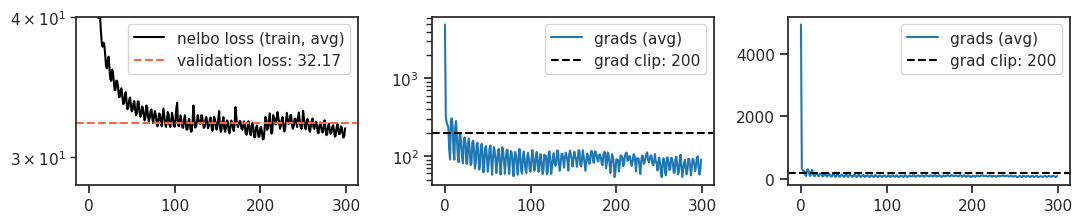

In [7]:
fig, axes = create_figure(1, 3, (11, 2.4), layout='tight')

axes[0].plot(nelbo, color='k', label='nelbo loss (train, avg)')
axes[0].axhline(loss_vld['tot'], color='tomato', ls='--', label=f"validation loss: {loss_vld['tot']:0.2f}")
axes[0].legend()

for ax in axes[1:].flat:
    ax.plot(grads, label='grads (avg)')
    ax.axhline(kws_iter['max_grad_norm'], color='k', ls='--', label=f"grad clip: {kws_iter['max_grad_norm']}")
    ax.legend()
for i in range(2):
    axes[i].set_yscale('log')
axes[0].set_ylim(top=40)
plt.show()

### make some plots

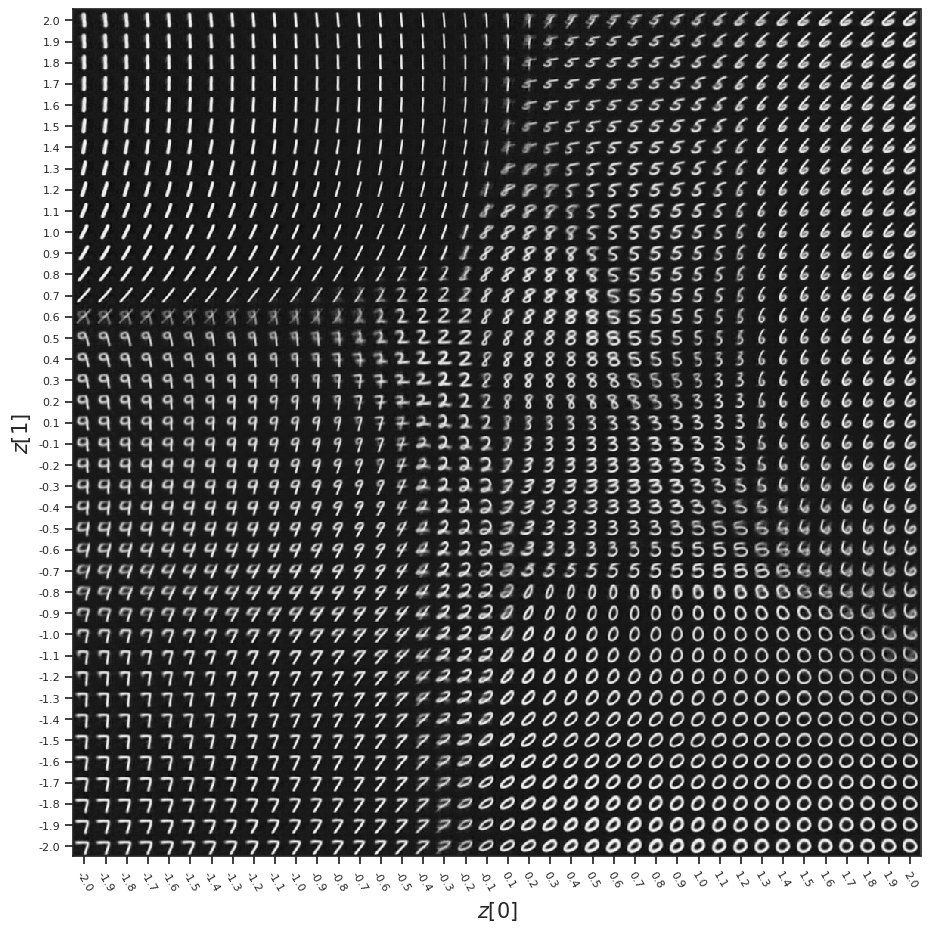

In [8]:
_ = plot_latent_space(gvae.dec, device, 2.0, 40)

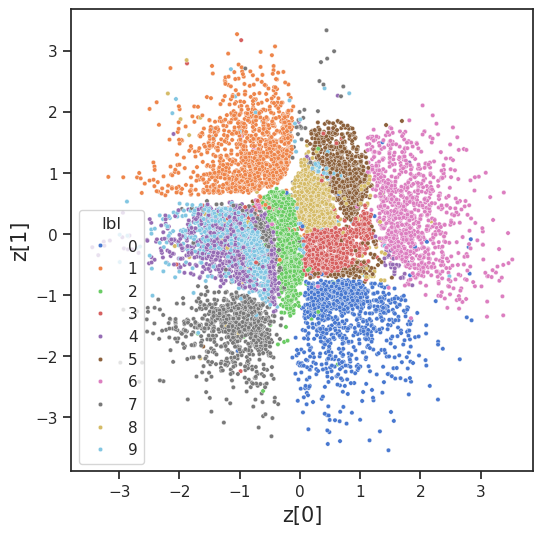

In [9]:
_ = plot_latent_scatter(emb, labels, (6, 6), 10)

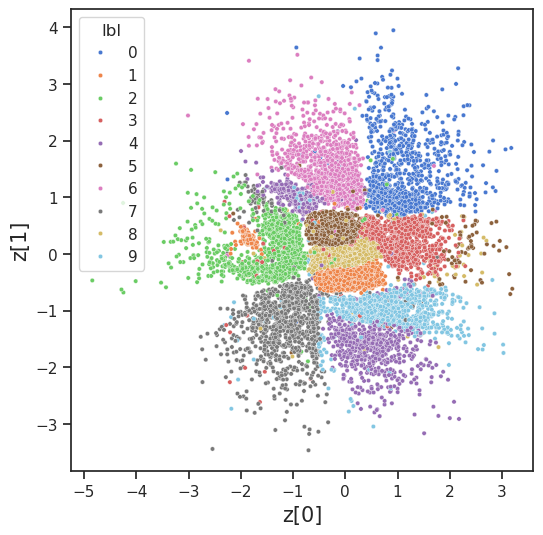

In [12]:
path = '/home/hadi/Documents/vae'

torch.save(
    obj={'epoch': epochs,
         'batch_size': batch_size,
         'model_state_dict': gvae.state_dict(),
         'optimizer_state_dict': optim.state_dict(),
         'loss': loss_vld},
    f=pjoin(path, '1.pt'),
)